# NanoEventsFactory example

Load a single local root file and play with the events.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np

from coffea.nanoevents import NanoEventsFactory, BaseSchema

In [3]:
events = NanoEventsFactory.from_root(
    #'/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/ntuple_phase2timing_H_XX_4b.root',
    #'/home/users/dspitzba/timing/CMSSW_11_3_1_patch1/src/Phase2Timing/ntuple_phase2timing.root',
    '/home/users/hswanson13/CMSSW_11_3_1_patch1/src/Phase2Timing/Phase2TimingAnalyzer/python/ntuple_phase2timing.root',
    schemaclass = BaseSchema,
    treepath='demo/tree',
    entry_stop = 1000).events()

In [4]:
events['e_pt'][0]

<Array [27.8, 17.3, 47.5, 26.4] type='4 * float32[parameters={"__doc__": "e_pt"}]'>

In [5]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import awkward as ak

In [6]:
import boost_histogram as bh

In [7]:
binning = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
binning

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5])

In [8]:
n_q = bh.Histogram(bh.axis.Variable(binning), storage=bh.storage.Weight())
n_q.fill(
    ak.num(events['e_pt'], axis=1),
    #weight=np.ones_like(ak.max(events['q_pt'], axis=1)),
)

Histogram(Variable([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]), storage=Weight()) # Sum: WeightedSum(value=200, variance=200)

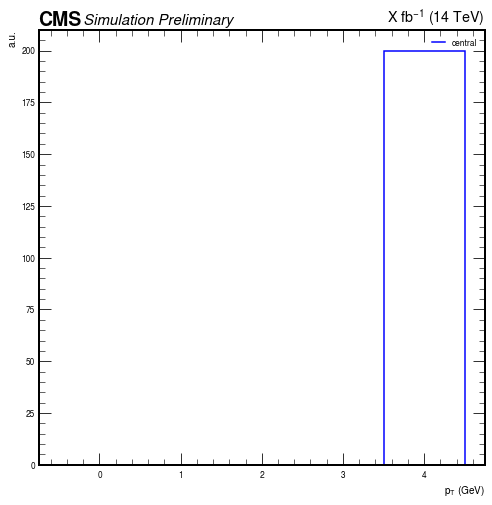

In [10]:
f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    [n_q.counts()],
    binning,
    histtype="step",
    stack=False,
    label=[r'central'],
    color=['blue'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel(r'a.u.')
ax.set_xlabel(r'$p_{T}\ (GeV)$')

plt.legend()

In [37]:
binning = np.linspace(0,100,11)

lead_q_pt = bh.Histogram(bh.axis.Variable(binning), storage=bh.storage.Weight())
lead_q_pt.fill(
    ak.fill_none(ak.max(events['q_pt'], axis=1), -99),
    #weight=np.ones_like(ak.max(events['q_pt'], axis=1)),
)

trail_q_pt = bh.Histogram(bh.axis.Variable(binning), storage=bh.storage.Weight())
trail_q_pt.fill(
    ak.fill_none(ak.min(events['q_pt'], axis=1), -99),
    #weight=np.ones_like(ak.max(events['q_pt'], axis=1)),
)

Histogram(Variable([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]), storage=Weight()) # Sum: WeightedSum(value=190, variance=190) (WeightedSum(value=200, variance=200) with flow)

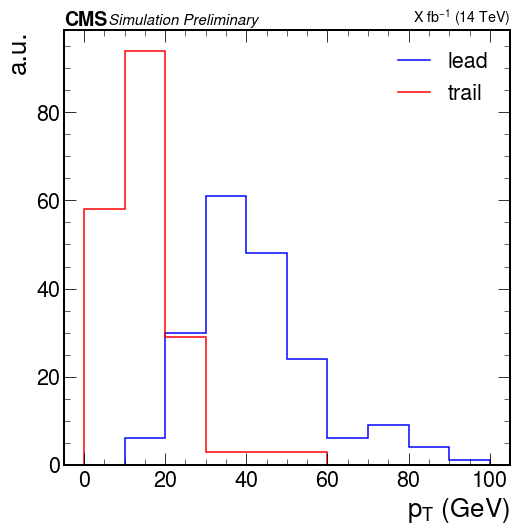

In [38]:
f, ax = plt.subplots(figsize=(8, 8))

hep.histplot(
    [lead_q_pt.counts(), trail_q_pt.counts()],
    binning,
    histtype="step",
    stack=False,
    label=[r'lead', r'trail'],
    color=['blue', 'red'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel(r'a.u.')
ax.set_xlabel(r'$p_{T}\ (GeV)$')

plt.legend()

In [9]:
def get_four_vec_fromPtEtaPhiM(cand, pt, eta, phi, M, copy=True):
    '''
    Get a LorentzVector from a NanoAOD candidate with custom pt, eta, phi and mass
    All other properties are copied over from the original candidate
    '''
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    vec4 = ak.zip(
        {
            "pt": pt,
            "eta": eta,
            "phi": phi,
            "mass": M,
        },
        with_name="PtEtaPhiMLorentzVector",
    )
    if copy:
        vec4.__dict__.update(cand.__dict__)
    return vec4

In [59]:
def choose(first, n=2):
    tmp = ak.combinations(first, n)
    combs = tmp['0']
    for i in range(1,n):
        combs = combs.__add__(tmp[str(i)])
    for i in range(n):
        combs[str(i)] = tmp[str(i)]
    return combs

In [60]:
def cross(first, second):
    tmp = ak.cartesian([first, second])
    combs = (tmp['0'] + tmp['1'])
    combs['0'] = tmp['0']
    combs['1'] = tmp['1']
    return combs

In [61]:
def delta_phi(first, second):
    return np.arccos(np.cos(first.phi - second.phi))

def delta_r2(first, second):
    return (first.eta - second.eta) ** 2 + delta_phi(first, second) ** 2
    
def delta_r(first, second):
    return np.sqrt(delta_r2(first, second))

def match(first, second, deltaRCut=0.4):
    drCut2 = deltaRCut**2
    combs = ak.cartesian([first, second], nested=True)
    return ak.any((delta_r2(combs['0'], combs['1'])<drCut2), axis=2)

In [62]:
gen_ele = get_four_vec_fromPtEtaPhiM(None, events['e_pt'], events['e_eta'], events['e_phi'], ak.zeros_like(events['e_phi']), copy=False)
#Q['p4'] = Q

In [63]:
reco_track = get_four_vec_fromPtEtaPhiM(None, events['track_pt'], events['track_eta'], events['track_phi'], ak.zeros_like(events['track_phi']), copy=False)

In [69]:
dielectron = choose(gen_ele, n=2)
dielectron

<LorentzVectorArray [[{x: -3.52, y: 11.3, ... mass: 0}}]] type='200 * var * Lore...'>

In [65]:
track_ele = cross(gen_ele, reco_track)
track_ele

<LorentzVectorArray [[{x: 3.31, y: 28.9, ... mass: 0}}]] type='200 * var * Loren...'>

In [66]:
matched_track = match(reco_track, gen_ele, deltaRCut=0.2)

In [44]:
ak.num(reco_track[matched_track], axis=1)

<Array [0, 2, 2, 1, 1, 6, ... 0, 1, 2, 1, 0, 2] type='200 * int64'>

In [45]:
reco_track[matched_track].pt

<Array [[], [1.97, 0.895, ... [0.681, 1.04]] type='200 * var * float32[parameter...'>

In [46]:
gen_ele.pt[0]

<Array [27.8, 17.3, 47.5, 26.4] type='4 * float32[parameters={"__doc__": "e_pt"}]'>

In [50]:
delta_r(track_ele['0'], track_ele['1'])

<Array [[0.767, 0.545, 0.822, ... 1.35, 2.58]] type='200 * var * float32'>

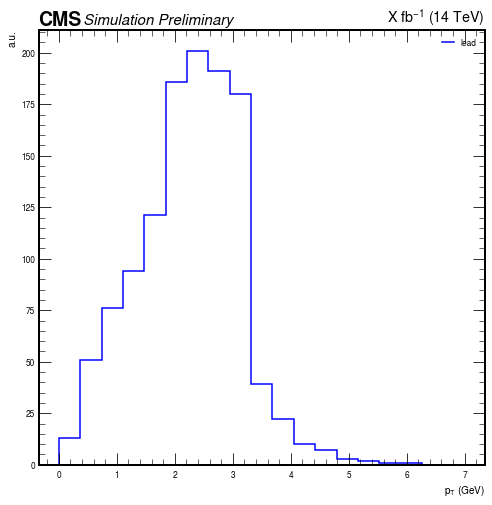

In [70]:
f, ax = plt.subplots(figsize=(8, 8))

binning = np.linspace(0,7,20)

delta_r_hist = bh.Histogram(bh.axis.Variable(binning), storage=bh.storage.Weight())
delta_r_hist.fill(ak.flatten(delta_r(dielectron['0'], dielectron['1']), axis=1))

hep.histplot(
    [delta_r_hist.counts()],
    binning,
    histtype="step",
    stack=False,
    label=[r'lead'],
    color=['blue'],
    ax=ax,
    )

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='X',
    com=14,
    loc=0,
    ax=ax,
    fontsize=15,
)

ax.set_ylabel(r'a.u.')
ax.set_xlabel(r'$p_{T}\ (GeV)$')

plt.legend()

In [52]:
ak.flatten(delta_r(track_ele['0'], track_ele['1']), axis=1)

<Array [0.767, 0.545, 0.822, ... 1.35, 2.58] type='87184 * float32'>